<a href="https://colab.research.google.com/github/preetham-saya/Gen-AI/blob/main/GAI_Exp_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
batch_size = 128
lr = 0.0002
z_dim = 100   # latent vector size
epochs = 30
num_classes = 10
img_size = 28 * 28

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1,1]
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 151MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 37.5MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 92.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.80MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # concatenate noise and label embedding
        c = self.label_emb(labels)
        x = torch.cat([noise, c], dim=1)
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(img_size + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = torch.cat([img, c], dim=1)
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(z_dim, num_classes, img_size).to(device)
D = Discriminator(num_classes, img_size).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_curr = imgs.size(0)
        imgs = imgs.view(batch_size_curr, -1).to(device)
        labels = labels.to(device)

        # real and fake labels
        real = torch.ones(batch_size_curr, 1).to(device)
        fake = torch.zeros(batch_size_curr, 1).to(device)

In [ ]:
        z = torch.randn(batch_size_curr, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size_curr,)).to(device)
        gen_imgs = G(z, gen_labels)

        real_loss = criterion(D(imgs, labels), real)
        fake_loss = criterion(D(gen_imgs.detach(), gen_labels), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

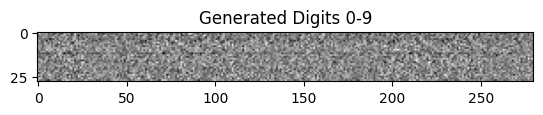

In [ ]:
 if (epoch+1) % 5 == 0:
        z = torch.randn(10, z_dim).to(device)
        labels_test = torch.arange(0, 10).to(device)
        gen_imgs = G(z, labels_test).view(-1, 1, 28, 28).cpu().detach()

        grid = torch.cat([gen_imgs[i] for i in range(10)], dim=2).squeeze()
        plt.imshow(grid, cmap="gray")
        plt.title("Generated Digits 0-9")
        plt.show()